In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


### Exploring WIDS 2020 Datathon Dataset

**Goal:** Create a model that uses data from the first 24hrs of intensive care to predict patient survival. 

**Dataset:** MIT's GOSSIS has provided a dataset of hospital intensive care visits. 

**Details of the data:**
- timeframe is 1 year
- over 130,000 ICU vists from patients 
- multiple hospitals 
- hospitals are geographically spread out

In [2]:
# read in the data
pt_df = pd.read_csv('../data/training_v2.csv')
pt_df.shape

(91713, 186)

In [3]:
# looking at the first couple of rows of data 
pt_df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [4]:
# what columns are available here 
pt_df.columns.to_list()


['encounter_id',
 'patient_id',
 'hospital_id',
 'hospital_death',
 'age',
 'bmi',
 'elective_surgery',
 'ethnicity',
 'gender',
 'height',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_m

In [5]:
# subsetting my data to focus on apache covariates 
pt_df_ap = pt_df[pt_df.columns[0:46]]

In [65]:
pt_df_ap.dtypes

encounter_id               int64
patient_id                 int64
hospital_id                int64
hospital_death             int64
age                      float64
bmi                      float64
elective_surgery           int64
ethnicity                 object
gender                    object
height                   float64
hospital_admit_source     object
icu_admit_source          object
icu_id                     int64
icu_stay_type             object
icu_type                  object
pre_icu_los_days         float64
readmission_status         int64
weight                   float64
albumin_apache           float64
apache_2_diagnosis       float64
apache_3j_diagnosis      float64
apache_post_operative      int64
arf_apache               float64
bilirubin_apache         float64
bun_apache               float64
creatinine_apache        float64
fio2_apache              float64
gcs_eyes_apache          float64
gcs_motor_apache         float64
gcs_unable_apache        float64
gcs_verbal

### Quick Overview of Demographic variables 

In [8]:
pt_df_ap.iloc[:,0:18].describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,91713.0,88993.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,0.0,84.028340
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,0.0,25.011497
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,0.0,38.600000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,0.0,66.800000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,0.0,80.300000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,0.0,97.100000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,0.0,186.000000


In [7]:
pt_df_ap.iloc[:,0:18].describe(include =["O"])

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
count,90318,91688,70304,91601,91713,91713
unique,6,2,15,5,3,8
top,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
freq,70684,49469,36962,54060,86183,50586


In [ ]:
# what values are high in nulls, if they are to be used need to take this into account 
pt_df_ap.isna().sum().sort_values(ascending = False)

In [ ]:
# are all the patients that are in the dataset only present once
pt_df['patient_id'].nunique() == len(pt_df['patient_id'])


In [ ]:
ct = pd.crosstab(pt_df_ap['gender'],pt_df_ap['hospital_death'])
ct

## Looking at apache covariates 

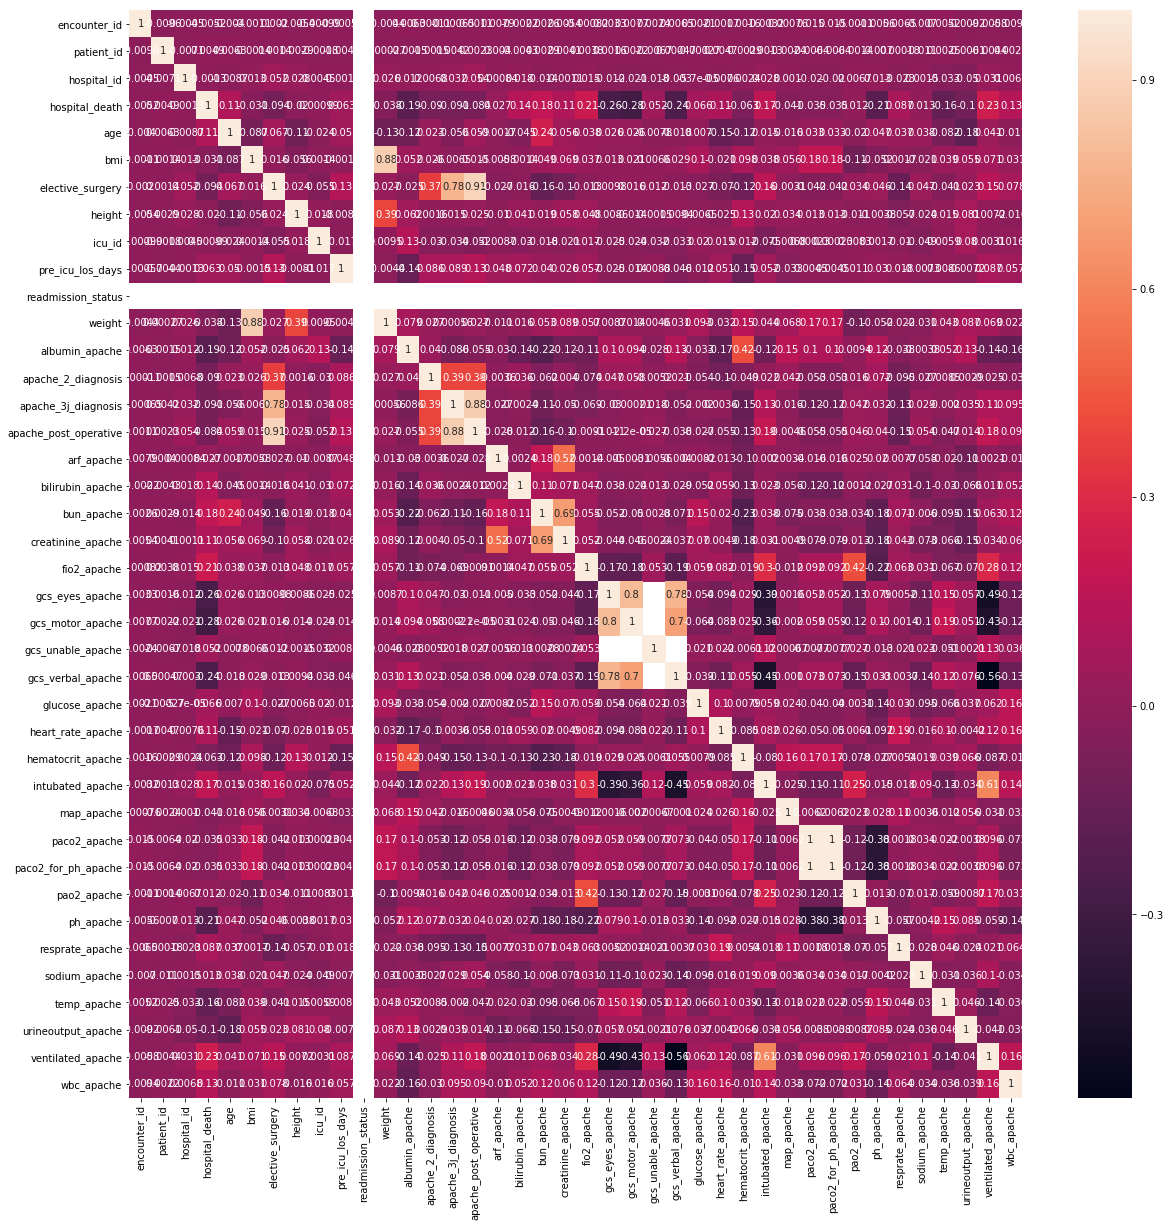

In [20]:
# looking at the correlation matrix
cormat = pt_df_ap.corr()
plt.subplots(figsize=(20, 20))
sns.heatmap(cormat, annot = True)

### Observations:
- there are some obvious correlations between variables like weight, height, and bmi
- when i look at hospital death the apache variables that I see the negative corr are the gcs_Eyes, gcs_motor, and gcs_verable
    - interestingly enough these are used to assess the level of consciouness in a person after a brain injury, potential car crash or sports injury. So, low-levels of these mean that they are not testable. High-Levels mean that they are 
    - generally a brain injurty would score around an 8 or less on the summation of these 3 fields! 
- Also found out that some of these are used together and summed as a score! so, for example apache II is made up of 12 apache variables and is used to score from 0 - 71 pts

In [32]:
## continuing with that lets look at the distribution of those columns for those who lived and died 
gcs_subset = pt_df_ap[['patient_id','hospital_id','hospital_death','ethnicity','gender','hospital_admit_source','gcs_eyes_apache','gcs_motor_apache','gcs_verbal_apache']]


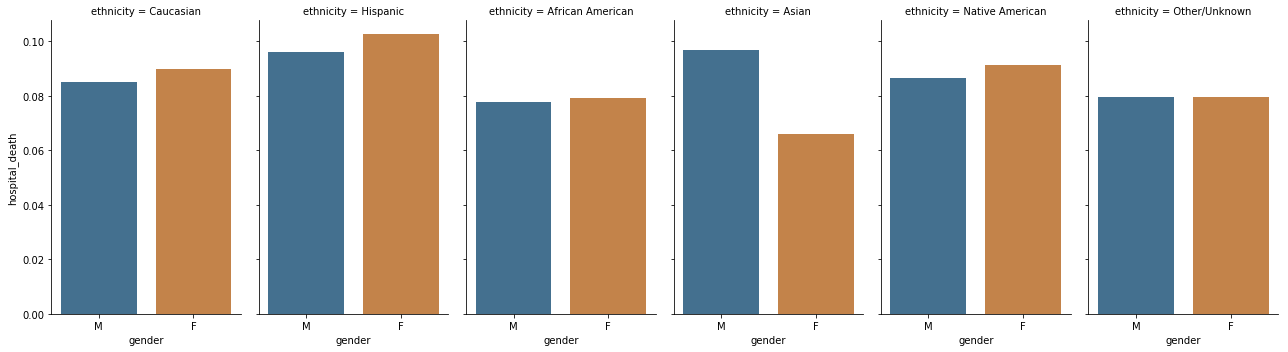

In [38]:
g = sns.catplot(x="gender", y="hospital_death", col="ethnicity",
                data=gcs_subset, saturation=.5,
                kind="bar", ci=None, aspect=.6)

In [88]:
pt_df_ap[pt_df_ap['ethnicity'] == 'Asian']['hospital_death'].value_counts()

0    1036
1      93
Name: hospital_death, dtype: int64

In [89]:
pt_df_ap[(pt_df_ap['ethnicity'] == 'Asian')]['gender'].value_counts()

M    598
F    531
Name: gender, dtype: int64

In [90]:
pd.crosstab(pt_df_ap[(pt_df_ap['ethnicity'] == 'Asian')]['gender'],pt_df_ap[pt_df_ap['ethnicity'] == 'Asian']['hospital_death'] )

hospital_death,0,1
gender,,
F,496,35
M,540,58


### for our exsiting dataset it looks like female have a higher rate of death in the ICU, but when we look at Asian in particular we see a stark comparison and that is that males have more hospital deaths

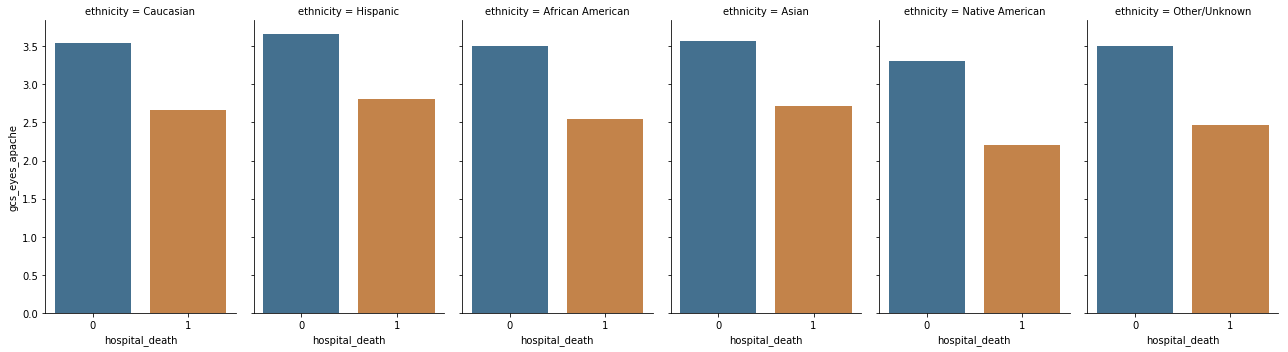

In [35]:
g = sns.catplot(x="hospital_death", y="gcs_eyes_apache", col="ethnicity",
                data=gcs_subset, saturation=.5,
                kind="bar", ci=None, aspect=.6)

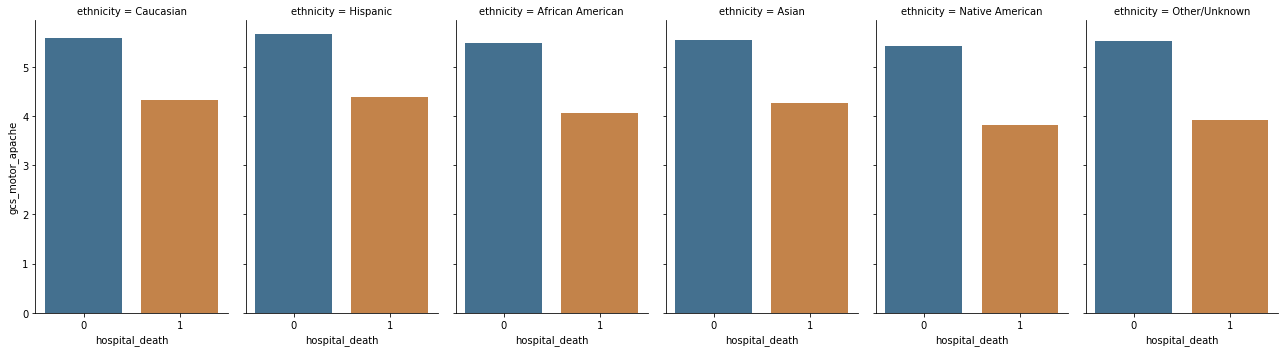

In [36]:
g = sns.catplot(x="hospital_death", y="gcs_motor_apache", col="ethnicity",
                data=gcs_subset, saturation=.5,
                kind="bar", ci=None, aspect=.6)

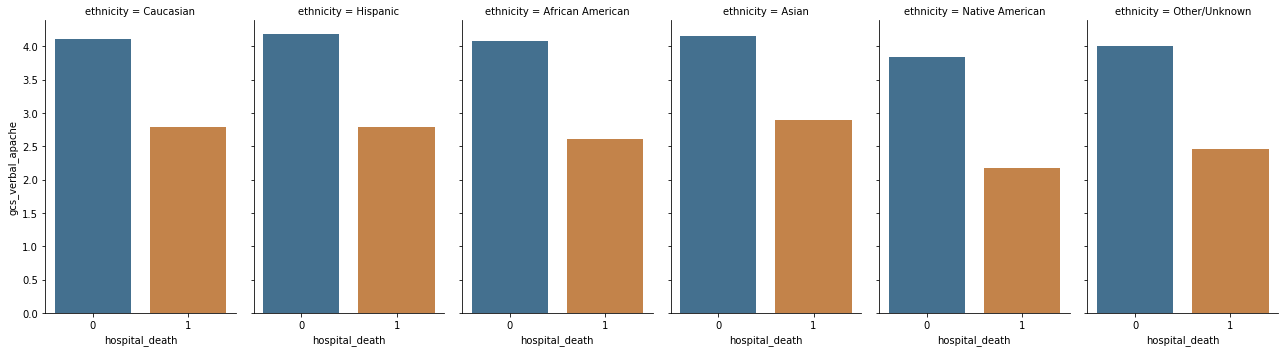

In [39]:
g = sns.catplot(x="hospital_death", y="gcs_verbal_apache", col="ethnicity",
                data=gcs_subset, saturation=.5,
                kind="bar", ci=None, aspect=.6)

In [40]:
# all of the plots above our consistent with our understanding of what we have read on gcs lets observe this with a sum of these variables 
gcs_subset['gcs_score'] = gcs_subset['gcs_eyes_apache'] + gcs_subset['gcs_verbal_apache'] + gcs_subset['gcs_motor_apache']

/Users/vivianahernandez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


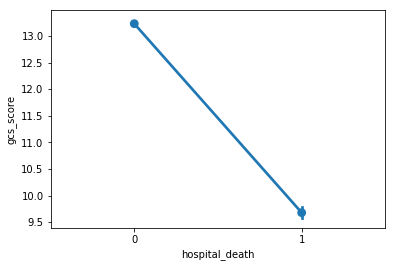

In [44]:
ax = sns.pointplot(x="hospital_death", y="gcs_score", data=gcs_subset)

In [51]:
gcs_subset['gcs_score'].isnull().sum() / len(gcs_subset['gcs_score']) * 100 

2.072770490552048

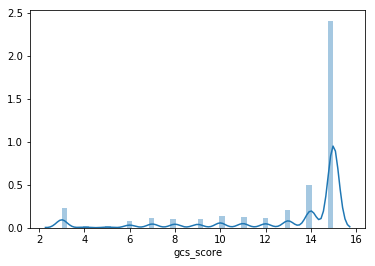

In [55]:
# the majority of our sample sizes distribution is high score which is indicative our imbalanced sample of death and nondeaths
sns.distplot(gcs_subset['gcs_score'].dropna())

In [57]:
dead_gcs_subset = gcs_subset[gcs_subset['hospital_death'] == 1]

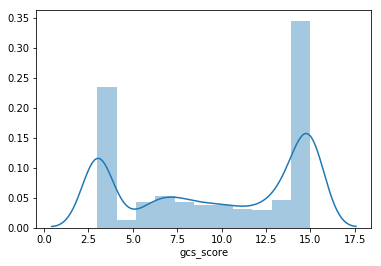

In [60]:
ax = sns.distplot(dead_gcs_subset['gcs_score'].dropna())

In [61]:
# this is a binomial distribution for those that experience hospital death
# be careful about any averaging on this variable especially for those who experience death because it won't be representative 

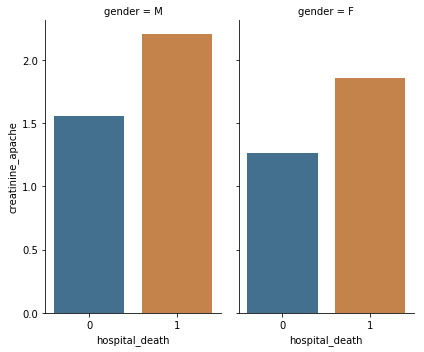

In [69]:
g = sns.catplot(x="hospital_death", y="creatinine_apache", col = 'gender',
                data=pt_df_ap, saturation=.5,
                kind="bar", ci=None, aspect=.6)

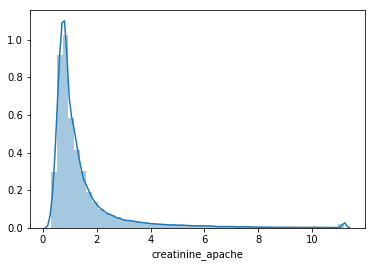

In [72]:
ax = sns.distplot(pt_df_ap['creatinine_apache'].dropna())

In [73]:
# high creatine values result in death, so the distribution we have here is skewed.

In [74]:
pt_df['apache_3j_bodysystem'].value_counts()

Cardiovascular          29999
Neurological            11896
Sepsis                  11740
Respiratory             11609
Gastrointestinal         9026
Metabolic                7650
Trauma                   3842
Genitourinary            2172
Musculoskeletal/Skin     1166
Hematological             638
Gynecological             313
Name: apache_3j_bodysystem, dtype: int64

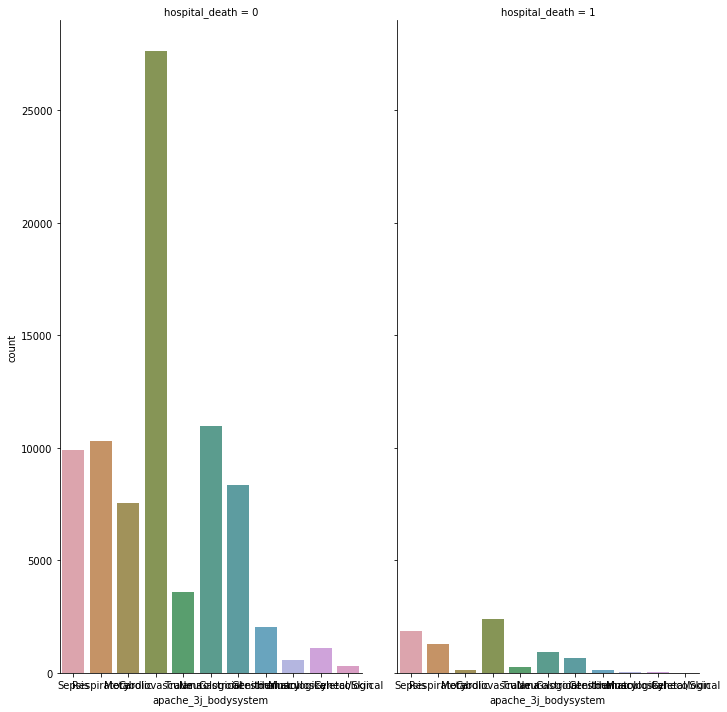

In [86]:
g = sns.catplot(x="apache_3j_bodysystem", col = 'hospital_death',
                data=pt_df, saturation=.5,
                kind="count", ci=None, height = 10 ,aspect=.5)

In [ ]:
pt_df_ap.corr()['hospital_death'].